In [1]:
import triton
import triton.language as tl
import torch
import torch.nn.functional as F
from triton.runtime import driver

In [2]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [3]:
properties = driver.active.utils.get_device_properties(DEVICE.index)

In [4]:
properties

{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 64,
 'warpSize': 32,
 'sm_clock_rate': 1695000,
 'mem_clock_rate': 8001000,
 'mem_bus_width': 384}

In [ ]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE': 16}, num_stages=3, num_warps=1),
        # triton.Config({'BLOCK_SIZE': 16}, num_stages=3, num_warps=2),
        # triton.Config({'BLOCK_SIZE': 8}, num_stages=8, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 32}, num_stages=8, num_warps=4),
        # triton.Config({'BLOCK_SIZE': 8}, num_stages=3, num_warps=8),
        # triton.Config({'BLOCK_SIZE': 16}, num_stages=3, num_warps=8),
    ],
    key=['height', 'width', 'stride', 'kH', 'kW'],
)
@triton.jit
def conv2d_kernel(input_ptr: torch.Tensor, kernel_ptr: torch.Tensor, output: torch.Tensor, 
                  in_batch_stride: int, in_channel_stride: int, out_batch_stride: int, out_channel_stride: int, 
                  in_channels: int, out_channels: int, height: int, width: int, 
                  k_out_channel_stride: int, k_in_channel_stride: int, stride: int, kH: tl.constexpr, kW: tl.constexpr, 
                  max_kH: tl.constexpr, max_kW: tl.constexpr, BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr): 
    
    batch_idx = tl.program_id(0) // out_channels
    out_c = tl.program_id(0) % out_channels
    tile_row = tl.program_id(1)
    tile_col = tl.program_id(2)
    
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    
    OUT_TILE_HEIGHT = BLOCK_SIZE - kH + 1
    OUT_TILE_WIDTH = BLOCK_SIZE - kW + 1
    
    out_tile_row = tile_row * OUT_TILE_HEIGHT
    out_tile_col = tile_col * OUT_TILE_WIDTH
    
    kernel_row_offset = tl.arange(0, max_kH)
    
    kernel_col_offset = tl.arange(0, max_kW)

    # Create a mask for valid kernel indices.
    kernel_mask = (kernel_row_offset[:, None] < kH) & (kernel_col_offset[None, :] < kW)
    
    # for i in tl.range(0, OUT_TILE_HEIGHT, num_stages=num_stages):
    #     for j in tl.range(0, OUT_TILE_WIDTH, num_stages=num_stages):
        
    #         out_row = out_tile_row + i
    #         out_col = out_tile_col + j
    # Create vector of row offsets and column offsets.
    i = tl.arange(0, OUT_TILE_HEIGHT)[:, None]  # Shape: (OUT_TILE_HEIGHT, 1)
    j = tl.arange(0, OUT_TILE_WIDTH)[None, :]    # Shape: (1, OUT_TILE_WIDTH)

    # Compute the entire tile's output indices in one go.
    out_rows = out_tile_row + i              # Shape: (OUT_TILE_HEIGHT, 1)
    out_cols = out_tile_col + j              # Shape: (1, OUT_TILE_WIDTH)
    valid_mask = (out_rows < out_height) & (out_cols < out_width)
    
    acc = 0.0
    input_rows = out_rows * stride
    input_cols = out_cols * stride
    for c in tl.range(0, in_channels, num_stages=num_stages):
        # Load a full kernel block using masked load.
        kernel_block = tl.load(
            kernel_ptr + out_c * k_out_channel_stride + c * k_in_channel_stride + kernel_row_offset[:, None] * kW + kernel_col_offset[None, :],
            mask=kernel_mask, other=0.0
        )
        patch_ptr = input_ptr + batch_idx * in_batch_stride + c * in_channel_stride + input_rows * width + input_cols
        input_patch = patch_ptr + kernel_row_offset[:, None] * width + kernel_col_offset[None, :]
        mask = (input_rows + kernel_row_offset[:, None] < height) & (input_cols + kernel_col_offset[None, :] < width) & kernel_mask
        input_block = tl.load(input_patch, mask = mask, other=0.0)
        
        acc += tl.sum(input_block * kernel_block, axis=[0, 1])
    tl.store(output + batch_idx * out_batch_stride + out_c * out_channel_stride + out_row * out_width + out_col, acc, mask=valid_mask)
                        
                    
        

In [35]:
def conv2d(input_tensor: torch.Tensor, kernel_tensor: torch.Tensor,
           num_batch: int, in_channels: int, out_channels: int, height: int, width: int, stride: int):
    
    kH, kW = 3,3
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    output_tensor = torch.empty(num_batch, out_channels, out_height, out_width, device='cuda', dtype=torch.float32)
    
    def grid_fn(meta):
        # Extract the BLOCK_SIZE from the current configuration
        block_size = meta['BLOCK_SIZE']
        
        out_tile_height = block_size - kH + 1
        out_tile_width = block_size - kW + 1
        
        # Ensure tiles are at least 1x1
        out_tile_height = max(1, out_tile_height)
        out_tile_width = max(1, out_tile_width)
        
        num_tile_rows = (out_height + out_tile_height - 1) // out_tile_height
        num_tile_cols = (out_width + out_tile_width - 1) // out_tile_width
        
        return (num_batch * out_channels, num_tile_rows, num_tile_cols)

    # The grid is 2D.
    grid = grid_fn
    max_kH, max_kW = triton.next_power_of_2(kH), triton.next_power_of_2(kW)
    
    conv2d_kernel[grid](input_tensor, kernel_tensor, output_tensor,
                        input_tensor.stride(0), input_tensor.stride(1), output_tensor.stride(0), output_tensor.stride(1), 
                        in_channels, out_channels, height, width,
                        kernel_tensor.stride(0), kernel_tensor.stride(1), stride, kH, kW, max_kH, max_kW)
    
    
    return output_tensor


In [37]:
# Example dimensions and hyperparameters.
num_batch, in_channels, height, width = 16, 2, 1024, 1024     # Input dimensions.
out_channels, kH, kW = 16, 3, 3                # Kernel dimensions.
stride = 1
input_tensor = torch.randn(num_batch, in_channels, height, width, device='cuda', dtype=torch.float32)
kernel_tensor = torch.randn(out_channels, in_channels, kH, kW, device='cuda', dtype=torch.float32)
output_tensor = conv2d(input_tensor, kernel_tensor, num_batch=num_batch, 
                       in_channels=in_channels, out_channels=out_channels, 
                       height=height, width=width, stride=stride)
torch_output = F.conv2d(input_tensor, kernel_tensor).squeeze()
if torch.allclose(output_tensor, torch_output, rtol=1e-3, atol=1e-3):
    print("✅ Triton and Torch conv2d implementations match")
else:
    print("❌ Triton and Torch conv2d implementations differ")

CompilationError: at 34:8:
    kernel_col_offset = tl.arange(0, max_kW)

    # Create a mask for valid kernel indices.
    kernel_mask = (kernel_row_offset[:, None] < kH) & (kernel_col_offset[None, :] < kW)

    # for i in tl.range(0, OUT_TILE_HEIGHT, num_stages=num_stages):
    #     for j in tl.range(0, OUT_TILE_WIDTH, num_stages=num_stages):

    #         out_row = out_tile_row + i
    #         out_col = out_tile_col + j
    # Create vector of row offsets and column offsets.
    i = tl.arange(0, OUT_TILE_HEIGHT)[:, None]  # Shape: (OUT_TILE_HEIGHT, 1)
        ^

In [27]:
conv2d_kernel.best_config.kwargs, conv2d_kernel.best_config.num_stages, conv2d_kernel.best_config.num_warps

({'BLOCK_SIZE': 16}, 3, 1)

In [28]:
torch.cuda.empty_cache()
print(f"GPU: {torch.cuda.get_device_name()}")
print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Available memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

GPU: NVIDIA RTX A5000
Total memory: 25.31 GB
Available memory: 4.56 GB


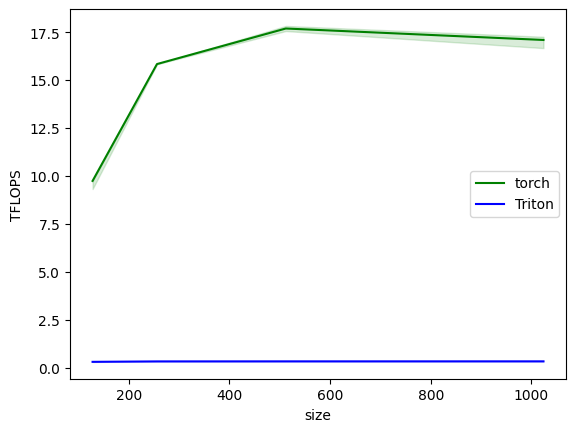

conv2d-performance-k3-fp32:
     size      torch    Triton
0   128.0   9.742091  0.309273
1   256.0  15.835745  0.332176
2   512.0  17.689421  0.334574
3  1024.0  17.091556  0.335216
None


In [30]:
# Configurate the benchmarks
configs = []
ref_lib = "torch"
kernel_sizes = [3]
sizes = [128, 256, 512, 1024]  # Use same values for both height and width
batch_size = 4
out_channels = 8
for ksz in kernel_sizes:
    configs.append(
        triton.testing.Benchmark(
            x_names=["size"],  # Single x-axis parameter that will be used for both height and width
            x_vals=sizes,     # Different possible values for the size
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Changed to TFLOPS (teraFLOPS)
            plot_name=f"conv2d-performance-k{ksz}-fp32",  # Name for the plot
            args={"kH": ksz, "kW": ksz, "batch_size": batch_size, "out_channels": out_channels},
        ))

@triton.testing.perf_report(configs)
def benchmark(size, provider, kH, kW, batch_size, out_channels):
    # Use size for both height and width
    
    height = size
    width = size
    in_channels = 3
    stride = 1
    input_tensor = torch.randn(batch_size, in_channels, height, width, device='cuda', dtype=torch.float32)
    kernel_tensor = torch.randn(out_channels, in_channels, kH, kW, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: F.conv2d(input_tensor, kernel_tensor), 
            quantiles=quantiles
        )
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: conv2d(input_tensor, kernel_tensor, num_batch=batch_size, in_channels=in_channels, out_channels=out_channels, 
                           height=height, width=width, kH=kH, kW=kW, stride=stride),
            quantiles=quantiles
        )
        
    
    # Calculate both FLOPS and memory bandwidth
    
    # Output dimensions
    out_height = (height - kH) // stride + 1
    out_width = (width - kW) // stride + 1
    
    
    # Calculate FLOPS
    # For each output element, we do:
    # - channels * kH * kW multiplications
    # - (channels * kH * kW - 1) additions
    # Total ops per output element: ~2 * channels * kH * kW (multiply-add)
    ops_per_output_element = 2 * out_channels * in_channels * kH * kW
    total_output_elements = batch_size * out_channels * out_height * out_width
    total_flops = ops_per_output_element * total_output_elements
    
    # Convert to TFLOPS (tera FLOPS)
    tflops = lambda ms: total_flops * 1e-12 / (ms * 1e-3)
    
    # Calculate memory bandwidth (for reference)
    bytes_per_element = 4  # float32
    input_size = batch_size * in_channels * height * width
    kernel_size = out_channels * in_channels * kH * kW
    output_size = batch_size * out_channels * out_height * out_width
    bytes_accessed = (input_size + kernel_size + output_size) * bytes_per_element
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    # Create a dual-metric benchmark result
    # Primary metric: TFLOPS
    result = tflops(ms), tflops(max_ms), tflops(min_ms)
    
    # Print memory bandwidth for reference
    bandwidth = gb_per_s(ms)
    # print(f"Size: {size}, Provider: {provider}, TFLOPS: {result[0]:.2f}, Memory BW: {bandwidth:.2f} GB/s")
    
    # Compute arithmetic intensity (FLOPS/byte)
    arithmetic_intensity = total_flops / bytes_accessed
    # print(f"  Arithmetic Intensity: {arithmetic_intensity:.2f} FLOPS/byte")
    
    return result

# Run the benchmark
print(benchmark.run(show_plots=True, print_data=True))

{'BLOCK_SIZE': 2}